### Using transformer models to understand what is going on in a scene to be given to the language model for better context

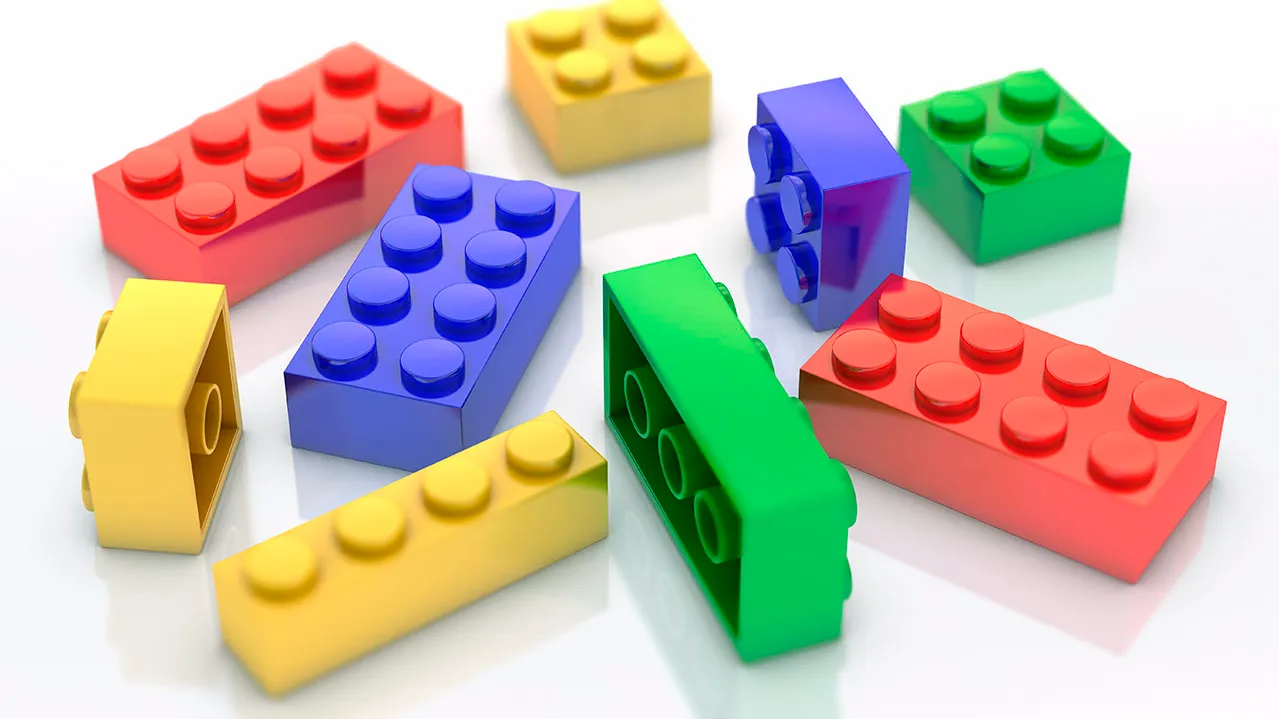

In [7]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
# raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
raw_image = Image.open("lego_blocks2.jpg")
raw_image

In [8]:
# conditional image captioning
text = "an image of  "
inputs = processor(raw_image, text, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

an image of a group of lego blocks sitting on top of a white surface


In [6]:

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

three lego blocks are arranged in a row on a table


#### Experiment with ViLD model from SayCan implemenation to implement zero shot object detection model [colab](https://colab.research.google.com/drive/1J2DsJevtHYIpIFwR_7HR_lHkrsnr2EMN#scrollTo=R0oD43SR4Kgs)


##### Load CLIP model

In [1]:
import clip
import numpy as np

In [2]:
# torch.cuda.set_per_process_memory_fraction(0.9, None)
clip_model, clip_preprocess = clip.load("ViT-B/32")
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", clip_model.visual.input_resolution)
print("Context length:", clip_model.context_length)
print("Vocab size:", clip_model.vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [3]:
from easydict import EasyDict

In [4]:
FLAGS = {
    'prompt_engineering': True,
    'this_is': True,
    'temperature': 100.0,
    'use_softmax': False,
}
FLAGS = EasyDict(FLAGS)
FLAGS

{'prompt_engineering': True,
 'this_is': True,
 'temperature': 100.0,
 'use_softmax': False}

In [5]:
# Parameters for drawing figure.
display_input_size = (10, 10)
overall_fig_size = (18, 24)
line_thickness = 1
fig_size_w = 35
# fig_size_h = min(max(5, int(len(category_names) / 2.5) ), 10)
mask_color =   'red'
alpha = 0.5

In [6]:
# if the item neam starts with a vowel character then start with 'an' else start with 'a'
def article(name):
  return "an" if name[0] in "aeiou" else "a"

In [7]:
# for processsing the class name sin teh result
def processed_name(name, rm_dot=False):
  # _ for lvis
  # / for obj365
  res = name.replace("_", " ").replace("/", " or ").lower()
  if rm_dot:
    res = res.rstrip(".")
  return res

In [8]:
single_template = [
    "a photo of {article} {}."
]

multiple_templates = [
    'There is {article} {} in the scene.',
    'There is the {} in the scene.',
    'a photo of {article} {} in the scene.',
    'a photo of the {} in the scene.',
    'a photo of one {} in the scene.',


    'itap of {article} {}.',
    'itap of my {}.',  # itap: I took a picture of
    'itap of the {}.',
    'a photo of {article} {}.',
    'a photo of my {}.',
    'a photo of the {}.',
    'a photo of one {}.',
    'a photo of many {}.',

    'a good photo of {article} {}.',
    'a good photo of the {}.',
    'a bad photo of {article} {}.',
    'a bad photo of the {}.',
    'a photo of a nice {}.',
    'a photo of the nice {}.',
    'a photo of a cool {}.',
    'a photo of the cool {}.',
    'a photo of a weird {}.',
    'a photo of the weird {}.',

    'a photo of a small {}.',
    'a photo of the small {}.',
    'a photo of a large {}.',
    'a photo of the large {}.',

    'a photo of a clean {}.',
    'a photo of the clean {}.',
    'a photo of a dirty {}.',
    'a photo of the dirty {}.',

    'a bright photo of {article} {}.',
    'a bright photo of the {}.',
    'a dark photo of {article} {}.',
    'a dark photo of the {}.',

    'a photo of a hard to see {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of {article} {}.',
    'a low resolution photo of the {}.',
    'a cropped photo of {article} {}.',
    'a cropped photo of the {}.',
    'a close-up photo of {article} {}.',
    'a close-up photo of the {}.',
    'a jpeg corrupted photo of {article} {}.',
    'a jpeg corrupted photo of the {}.',
    'a blurry photo of {article} {}.',
    'a blurry photo of the {}.',
    'a pixelated photo of {article} {}.',
    'a pixelated photo of the {}.',

    'a black and white photo of the {}.',
    'a black and white photo of {article} {}.',

    'a plastic {}.',
    'the plastic {}.',

    'a toy {}.',
    'the toy {}.',
    'a plushie {}.',
    'the plushie {}.',
    'a cartoon {}.',
    'the cartoon {}.',

    'an embroidered {}.',
    'the embroidered {}.',

    'a painting of the {}.',
    'a painting of a {}.',
]

In [9]:
# import pytorch
import torch
from tqdm import tqdm

In [10]:
def build_text_embedding(categories):
  # it will use multiple templates since prompt engineering is true
  if FLAGS.prompt_engineering:
    templates = multiple_templates
  else:
    templates = single_template

  run_on_gpu = torch.cuda.is_available()
  with torch.no_grad():
    all_text_embeddings = []
    print("Building text embeddings...")
    for category in tqdm(categories):
      texts = [
        template.format(processed_name(category["name"], rm_dot=True),
                        article=article(category["name"]))
        for template in templates]
      if FLAGS.this_is:
        texts = [
                 "This is " + text if text.startswith("a") or text.startswith("the") else text 
                 for text in texts
                 ]
      texts = clip.tokenize(texts) #tokenize
      if run_on_gpu:
        texts = texts.cuda()
      text_embeddings = clip_model.encode_text(texts) #embed with text encoder
      text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
      text_embedding = text_embeddings.mean(dim=0)
      text_embedding /= text_embedding.norm()
      all_text_embeddings.append(text_embedding)
    all_text_embeddings = torch.stack(all_text_embeddings, dim=1)
    if run_on_gpu:
      all_text_embeddings = all_text_embeddings.cuda()
  return all_text_embeddings.cpu().numpy().T

In [11]:
numbered_categories = [{"name": str(idx), "id": idx,} for idx in range(50)]
numbered_category_indices = {cat["id"]: cat for cat in numbered_categories}

In [13]:
def nms(dets, scores, thresh, max_dets=1000):
  """Non-maximum suppression.
  Args:
    dets: [N, 4]
    scores: [N,]
    thresh: iou threshold. Float
    max_dets: int.
  """
  y1 = dets[:, 0]
  x1 = dets[:, 1]
  y2 = dets[:, 2]
  x2 = dets[:, 3]

  areas = (x2 - x1) * (y2 - y1)
  order = scores.argsort()[::-1]

  keep = []
  while order.size > 0 and len(keep) < max_dets:
    i = order[0]
    keep.append(i)

    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])

    w = np.maximum(0.0, xx2 - xx1)
    h = np.maximum(0.0, yy2 - yy1)
    intersection = w * h
    overlap = intersection / (areas[i] + areas[order[1:]] - intersection + 1e-12)

    inds = np.where(overlap <= thresh)[0]
    order = order[inds + 1]
  return keep

In [14]:
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

STANDARD_COLORS = ["White"]

In [16]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color="red",
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.

  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.

  Each string in display_str_list is displayed on a separate line above the
  bounding box in black text on a rectangle filled with the input "color".
  If the top of the bounding box extends to the edge of the image, the strings
  are displayed below the bounding box.

  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  try:
    font = ImageFont.truetype("arial.ttf", 24)
  except IOError:
    font = ImageFont.load_default()

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_left = min(5, left)
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                          text_bottom)],
        fill=color)
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill="black",
        font=font)
    text_bottom -= text_height - 2 * margin

In [17]:
def draw_bounding_box_on_image_array(image,
                                     ymin,
                                     xmin,
                                     ymax,
                                     xmax,
                                     color="red",
                                     thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):
  """Adds a bounding box to an image (numpy array).

  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.

  Args:
    image: a numpy array with shape [height, width, 3].
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
  draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
                             thickness, display_str_list,
                             use_normalized_coordinates)
  np.copyto(image, np.array(image_pil))

In [18]:
def draw_mask_on_image_array(image, mask, color="red", alpha=0.4):
  """Draws mask on an image.

  Args:
    image: uint8 numpy array with shape (img_height, img_height, 3)
    mask: a uint8 numpy array of shape (img_height, img_height) with
      values between either 0 or 1.
    color: color to draw the keypoints with. Default is red.
    alpha: transparency value between 0 and 1. (default: 0.4)

  Raises:
    ValueError: On incorrect data type for image or masks.
  """
  if image.dtype != np.uint8:
    raise ValueError("`image` not of type np.uint8")
  if mask.dtype != np.uint8:
    raise ValueError("`mask` not of type np.uint8")
  if np.any(np.logical_and(mask != 1, mask != 0)):
    raise ValueError("`mask` elements should be in [0, 1]")
  if image.shape[:2] != mask.shape:
    raise ValueError("The image has spatial dimensions %s but the mask has "
                     "dimensions %s" % (image.shape[:2], mask.shape))
  rgb = ImageColor.getrgb(color)
  pil_image = Image.fromarray(image)

  solid_color = np.expand_dims(
      np.ones_like(mask), axis=2) * np.reshape(list(rgb), [1, 1, 3])
  pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert("RGBA")
  pil_mask = Image.fromarray(np.uint8(255.0*alpha*mask)).convert("L")
  pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
  np.copyto(image, np.array(pil_image.convert("RGB")))

In [19]:
import collections

In [20]:
def visualize_boxes_and_labels_on_image_array(
    image,
    boxes,
    classes,
    scores,
    category_index,
    instance_masks=None,
    instance_boundaries=None,
    use_normalized_coordinates=False,
    max_boxes_to_draw=20,
    min_score_thresh=.5,
    agnostic_mode=False,
    line_thickness=1,
    groundtruth_box_visualization_color="black",
    skip_scores=False,
    skip_labels=False,
    mask_alpha=0.4,
    plot_color=None,
):
  """Overlay labeled boxes on an image with formatted scores and label names.

  This function groups boxes that correspond to the same location
  and creates a display string for each detection and overlays these
  on the image. Note that this function modifies the image in place, and returns
  that same image.

  Args:
    image: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    instance_masks: a numpy array of shape [N, image_height, image_width] with
      values ranging between 0 and 1, can be None.
    instance_boundaries: a numpy array of shape [N, image_height, image_width]
      with values ranging between 0 and 1, can be None.
    use_normalized_coordinates: whether boxes is to be interpreted as
      normalized coordinates or not.
    max_boxes_to_draw: maximum number of boxes to visualize.  If None, draw
      all boxes.
    min_score_thresh: minimum score threshold for a box to be visualized
    agnostic_mode: boolean (default: False) controlling whether to evaluate in
      class-agnostic mode or not.  This mode will display scores but ignore
      classes.
    line_thickness: integer (default: 4) controlling line width of the boxes.
    groundtruth_box_visualization_color: box color for visualizing groundtruth
      boxes
    skip_scores: whether to skip score when drawing a single detection
    skip_labels: whether to skip label when drawing a single detection

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3) with overlaid boxes.
  """
  # Create a display string (and color) for every box location, group any boxes
  # that correspond to the same location.
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  box_to_instance_masks_map = {}
  box_to_score_map = {}
  box_to_instance_boundaries_map = {}
  
  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())
      if instance_masks is not None:
        box_to_instance_masks_map[box] = instance_masks[i]
      if instance_boundaries is not None:
        box_to_instance_boundaries_map[box] = instance_boundaries[i]
      if scores is None:
        box_to_color_map[box] = groundtruth_box_visualization_color
      else:
        display_str = ""
        if not skip_labels:
          if not agnostic_mode:
            if classes[i] in list(category_index.keys()):
              class_name = category_index[classes[i]]["name"]
            else:
              class_name = "N/A"
            display_str = str(class_name)
        if not skip_scores:
          if not display_str:
            display_str = "{}%".format(int(100*scores[i]))
          else:
            float_score = ("%.2f" % scores[i]).lstrip("0")
            display_str = "{}: {}".format(display_str, float_score)
          box_to_score_map[box] = int(100*scores[i])

        box_to_display_str_map[box].append(display_str)
        if plot_color is not None:
          box_to_color_map[box] = plot_color
        elif agnostic_mode:
          box_to_color_map[box] = "DarkOrange"
        else:
          box_to_color_map[box] = STANDARD_COLORS[
              classes[i] % len(STANDARD_COLORS)]

  # Handle the case when box_to_score_map is empty.
  if box_to_score_map:
    box_color_iter = sorted(
        box_to_color_map.items(), key=lambda kv: box_to_score_map[kv[0]])
  else:
    box_color_iter = box_to_color_map.items()

  # Draw all boxes onto image.
  for box, color in box_color_iter:
    ymin, xmin, ymax, xmax = box
    if instance_masks is not None:
      draw_mask_on_image_array(
          image,
          box_to_instance_masks_map[box],
          color=color,
          alpha=mask_alpha
      )
    if instance_boundaries is not None:
      draw_mask_on_image_array(
          image,
          box_to_instance_boundaries_map[box],
          color="red",
          alpha=1.0
      )
    draw_bounding_box_on_image_array(
        image,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=line_thickness,
        display_str_list=box_to_display_str_map[box],
        use_normalized_coordinates=use_normalized_coordinates)
    
  return image

In [21]:
import cv2

In [22]:
def paste_instance_masks(masks,
                         detected_boxes,
                         image_height,
                         image_width):
  """Paste instance masks to generate the image segmentation results.

  Args:
    masks: a numpy array of shape [N, mask_height, mask_width] representing the
      instance masks w.r.t. the `detected_boxes`.
    detected_boxes: a numpy array of shape [N, 4] representing the reference
      bounding boxes.
    image_height: an integer representing the height of the image.
    image_width: an integer representing the width of the image.

  Returns:
    segms: a numpy array of shape [N, image_height, image_width] representing
      the instance masks *pasted* on the image canvas.
  """

  def expand_boxes(boxes, scale):
    """Expands an array of boxes by a given scale."""
    # Reference: https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/boxes.py#L227  # pylint: disable=line-too-long
    # The `boxes` in the reference implementation is in [x1, y1, x2, y2] form,
    # whereas `boxes` here is in [x1, y1, w, h] form
    w_half = boxes[:, 2] * .5
    h_half = boxes[:, 3] * .5
    x_c = boxes[:, 0] + w_half
    y_c = boxes[:, 1] + h_half

    w_half *= scale
    h_half *= scale

    boxes_exp = np.zeros(boxes.shape)
    boxes_exp[:, 0] = x_c - w_half
    boxes_exp[:, 2] = x_c + w_half
    boxes_exp[:, 1] = y_c - h_half
    boxes_exp[:, 3] = y_c + h_half

    return boxes_exp

  # Reference: https://github.com/facebookresearch/Detectron/blob/master/detectron/core/test.py#L812  # pylint: disable=line-too-long
  # To work around an issue with cv2.resize (it seems to automatically pad
  # with repeated border values), we manually zero-pad the masks by 1 pixel
  # prior to resizing back to the original image resolution. This prevents
  # "top hat" artifacts. We therefore need to expand the reference boxes by an
  # appropriate factor.
  _, mask_height, mask_width = masks.shape
  scale = max((mask_width + 2.0) / mask_width,
              (mask_height + 2.0) / mask_height)

  ref_boxes = expand_boxes(detected_boxes, scale)
  ref_boxes = ref_boxes.astype(np.int32)
  padded_mask = np.zeros((mask_height + 2, mask_width + 2), dtype=np.float32)
  segms = []
  for mask_ind, mask in enumerate(masks):
    im_mask = np.zeros((image_height, image_width), dtype=np.uint8)
    # Process mask inside bounding boxes.
    padded_mask[1:-1, 1:-1] = mask[:, :]

    ref_box = ref_boxes[mask_ind, :]
    w = ref_box[2] - ref_box[0] + 1
    h = ref_box[3] - ref_box[1] + 1
    w = np.maximum(w, 1)
    h = np.maximum(h, 1)

    mask = cv2.resize(padded_mask, (w, h))
    mask = np.array(mask > 0.5, dtype=np.uint8)

    x_0 = min(max(ref_box[0], 0), image_width)
    x_1 = min(max(ref_box[2] + 1, 0), image_width)
    y_0 = min(max(ref_box[1], 0), image_height)
    y_1 = min(max(ref_box[3] + 1, 0), image_height)

    im_mask[y_0:y_1, x_0:x_1] = mask[
        (y_0 - ref_box[1]):(y_1 - ref_box[1]),
        (x_0 - ref_box[0]):(x_1 - ref_box[0])
    ]
    segms.append(im_mask)

  segms = np.array(segms)
  assert masks.shape[0] == segms.shape[0]
  return segms

In [23]:
def plot_mask(color, alpha, original_image, mask):
  rgb = ImageColor.getrgb(color)
  pil_image = Image.fromarray(original_image)

  solid_color = np.expand_dims(
      np.ones_like(mask), axis=2) * np.reshape(list(rgb), [1, 1, 3])
  pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert("RGBA")
  pil_mask = Image.fromarray(np.uint8(255.0*alpha*mask)).convert("L")
  pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
  img_w_mask = np.array(pil_image.convert("RGB"))
  return img_w_mask

In [24]:
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from PIL import Image

In [25]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
gpu_options

per_process_gpu_memory_fraction: 0.2

In [26]:
session = tf.Session(graph=tf.Graph(), config=tf.ConfigProto(gpu_options=gpu_options))
saved_model_dir = "/Users/kosisochukwuasuzu/Developer/machine_learning/llm-robotics/src/image_path_v2"
_ = tf.saved_model.loader.load(session, ["serve"], saved_model_dir)

Instructions for updating:
Use `tf.saved_model.load` instead.
INFO:tensorflow:Restoring parameters from /Users/kosisochukwuasuzu/Developer/machine_learning/llm-robotics/src/image_path_v2/variables/variables


In [27]:
def display_image(path_or_array, size=(10, 10)):
  if isinstance(path_or_array, str):
    image = np.asarray(Image.open(open(path_or_array, "rb")).convert("RGB"))
  else:
    image = path_or_array
  
  plt.figure(figsize=size)
  plt.imshow(image)
  plt.axis("off")
  plt.show()

In [42]:
def vild(image_path, category_name_string, params, plot_on=True, prompt_swaps=[]):
  #################################################################
  # Preprocessing categories and get params
  for a, b in prompt_swaps:
    category_name_string = category_name_string.replace(a, b)
  category_names = [x.strip() for x in category_name_string.split(";")]
  category_names = ["background"] + category_names
  categories = [{"name": item, "id": idx+1,} for idx, item in enumerate(category_names)]
  category_indices = {cat["id"]: cat for cat in categories}
  
  max_boxes_to_draw, nms_threshold, min_rpn_score_thresh, min_box_area, max_box_area = params
  fig_size_h = min(max(5, int(len(category_names) / 2.5) ), 10)


  #################################################################
  # Obtain results and read image
  roi_boxes, roi_scores, detection_boxes, scores_unused, box_outputs, detection_masks, visual_features, image_info = session.run(
        ["RoiBoxes:0", "RoiScores:0", "2ndStageBoxes:0", "2ndStageScoresUnused:0", "BoxOutputs:0", "MaskOutputs:0", "VisualFeatOutputs:0", "ImageInfo:0"],
        feed_dict={"Placeholder:0": [image_path,]})
  
  roi_boxes = np.squeeze(roi_boxes, axis=0)  # squeeze
  # no need to clip the boxes, already done
  roi_scores = np.squeeze(roi_scores, axis=0)

  detection_boxes = np.squeeze(detection_boxes, axis=(0, 2))
  scores_unused = np.squeeze(scores_unused, axis=0)
  box_outputs = np.squeeze(box_outputs, axis=0)
  detection_masks = np.squeeze(detection_masks, axis=0)
  visual_features = np.squeeze(visual_features, axis=0)

  image_info = np.squeeze(image_info, axis=0)  # obtain image info
  image_scale = np.tile(image_info[2:3, :], (1, 2))
  image_height = int(image_info[0, 0])
  image_width = int(image_info[0, 1])

  rescaled_detection_boxes = detection_boxes / image_scale # rescale

  # Read image
  image = np.asarray(Image.open(open(image_path, "rb")).convert("RGB"))
  assert image_height == image.shape[0]
  assert image_width == image.shape[1]


  #################################################################
  # Filter boxes

  # Apply non-maximum suppression to detected boxes with nms threshold.
  nmsed_indices = nms(
      detection_boxes,
      roi_scores,
      thresh=nms_threshold
      )

  # Compute RPN box size.
  box_sizes = (rescaled_detection_boxes[:, 2] - rescaled_detection_boxes[:, 0]) * (rescaled_detection_boxes[:, 3] - rescaled_detection_boxes[:, 1])

  # Filter out invalid rois (nmsed rois)
  valid_indices = np.where(
      np.logical_and(
        np.isin(np.arange(len(roi_scores), dtype=int), nmsed_indices),
        np.logical_and(
            np.logical_not(np.all(roi_boxes == 0., axis=-1)),
            np.logical_and(
              roi_scores >= min_rpn_score_thresh,
              np.logical_and(
                box_sizes > min_box_area,
                box_sizes < max_box_area
                )
              )
        )    
      )
  )[0]

  detection_roi_scores = roi_scores[valid_indices][:max_boxes_to_draw, ...]
  detection_boxes = detection_boxes[valid_indices][:max_boxes_to_draw, ...]
  detection_masks = detection_masks[valid_indices][:max_boxes_to_draw, ...]
  detection_visual_feat = visual_features[valid_indices][:max_boxes_to_draw, ...]
  rescaled_detection_boxes = rescaled_detection_boxes[valid_indices][:max_boxes_to_draw, ...]


  #################################################################
  # Compute text embeddings and detection scores, and rank results
  text_features = build_text_embedding(categories)
  
  raw_scores = detection_visual_feat.dot(text_features.T)
  if FLAGS.use_softmax:
    # scores_all = softmax(FLAGS.temperature * raw_scores, axis=-1)
    pass
  else:
    scores_all = raw_scores

  indices = np.argsort(-np.max(scores_all, axis=1))  # Results are ranked by scores
  indices_fg = np.array([i for i in indices if np.argmax(scores_all[i]) != 0])

  #################################################################
  # Plot detected boxes on the input image.
  ymin, xmin, ymax, xmax = np.split(rescaled_detection_boxes, 4, axis=-1)
  processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
  
  #################################################################
  # Print found_objects
  found_objects = []
  for a, b in prompt_swaps:
    category_names = [name.replace(b, a) for name in category_names]  # Extra prompt engineering.
  for anno_idx, proccessed_box in zip(indices[0:int(rescaled_detection_boxes.shape[0])], processed_boxes):
    scores = scores_all[anno_idx]
    if np.argmax(scores) == 0:
      continue
    found_object = category_names[np.argmax(scores)]
    if found_object == "background":
      continue
    # print("Found a", found_object, "with score:", np.max(scores))
    found_objects.append({"name": found_object, "score": np.max(scores), "bbox": proccessed_box})
  if not plot_on:
    return found_objects
  


  # segmentations = paste_instance_masks(detection_masks, processed_boxes, image_height, image_width)

  # if len(indices_fg) == 0:
  #   display_image(np.array(image), size=overall_fig_size)
  #   print("ViLD does not detect anything belong to the given category")

  # else:
  #   image_with_detections = visualize_boxes_and_labels_on_image_array(
  #       np.array(image),
  #       rescaled_detection_boxes[indices_fg],
  #       valid_indices[:max_boxes_to_draw][indices_fg],
  #       detection_roi_scores[indices_fg],    
  #       numbered_category_indices,
  #       instance_masks=segmentations[indices_fg],
  #       use_normalized_coordinates=False,
  #       max_boxes_to_draw=max_boxes_to_draw,
  #       min_score_thresh=min_rpn_score_thresh,
  #       skip_scores=False,
  #       skip_labels=True)

  #   # plt.figure(figsize=overall_fig_size)
  #   plt.imshow(image_with_detections)
  #   # plt.axis("off")
  #   plt.title("ViLD detected objects and RPN scores.")
  #   plt.show()

  return found_objects

In [43]:
category_names = ['blue block',
                  'red block',
                  'green block',
                  'orange block',
                  'yellow block',
                  'purple block',
                  'pink block',
                  'cyan block',
                  'brown block',
                  'gray block',

                  'blue bowl',
                  'red bowl',
                  'green bowl',
                  'orange bowl',
                  'yellow bowl',
                  'purple bowl',
                  'pink bowl',
                  'cyan bowl',
                  'brown bowl',
                  'gray bowl']
# category_names = ['block']
image_path = '/Users/kosisochukwuasuzu/Developer/machine_learning/llm-robotics/src/vision/lego_blocks5.jpg'

#@markdown ViLD settings.
category_name_string = ";".join(category_names)
max_boxes_to_draw = 8 #@param {type:"integer"}

# Extra prompt engineering: swap A with B for every (A, B) in list.
prompt_swaps = [('block', 'cube')]

nms_threshold = 0.4
min_rpn_score_thresh = 0.4
min_box_area = 10
max_box_area = 3000
vild_params = max_boxes_to_draw, nms_threshold, min_rpn_score_thresh, min_box_area, max_box_area
found_objects = vild(image_path, category_name_string, vild_params, plot_on=True, prompt_swaps=prompt_swaps)

Building text embeddings...


100%|██████████| 21/21 [00:12<00:00,  1.67it/s]


In [44]:
found_objects 
# bbox = x_min, y_min, x_diff, y_diff

[{'name': 'green block',
  'score': 0.31165114,
  'bbox': array([707.0869  , 253.85152 ,  30.112732,  34.534866], dtype=float32)},
 {'name': 'red block',
  'score': 0.29842833,
  'bbox': array([749.4446  , 345.6046  ,  26.583984,  31.388733], dtype=float32)},
 {'name': 'yellow block',
  'score': 0.28249547,
  'bbox': array([312.5098  , 212.56259 ,  28.922333,  42.096222], dtype=float32)},
 {'name': 'gray block',
  'score': 0.27806905,
  'bbox': array([813.7568  , 253.96567 ,  23.720215,  32.9993  ], dtype=float32)},
 {'name': 'blue block',
  'score': 0.27206054,
  'bbox': array([815.6407  , 290.32776 ,  25.872192,  35.60919 ], dtype=float32)},
 {'name': 'gray block',
  'score': 0.2687946,
  'bbox': array([566.4827   , 927.1609   ,   9.878113 ,   7.8079834], dtype=float32)},
 {'name': 'gray block',
  'score': 0.26429585,
  'bbox': array([691.036   , 346.12076 ,  29.663025,  27.137573], dtype=float32)}]

In [10]:
blocks = ["red", "green", "blue", "red"]
scene_description = ""


In [11]:
scene_description += f"There are {len(blocks)} blocks in the scene \n"
block_map = {}
for i in blocks:
    if i in block_map:
        block_map[i] += 1
    else:
        block_map[i] = 1
for key, value in block_map.items():
    plural = ""
    if value > 1:
        plural = "s"
    scene_description += f" {value} {key} block{plural} \n"
    

In [12]:
print(scene_description)

There are 4 blocks in the scene 
 2 red blocks 
 1 green block 
 1 blue block 

